Training codes for the VGG16 Networks

## VGG16 Training

In [1]:
import utils.data_utils as data_utils
import utils.train_utils as train_utils
from utils.model_selector import model_selector, free_gpu_memory
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import pandas as pd
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
import torch.optim as optim
import seaborn as sns
from torchvision.models import vgg16_bn, VGG16_BN_Weights
from sklearn.model_selection import KFold
import time

Hyperparameters


In [2]:
np.random.seed(42)
batch_verbose = 100
epochs = 2
batch_size = 4
current_path = "../RESULTS"
os.makedirs(current_path, exist_ok=True)
lr = 1e-7 
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using", device)

using cuda:0


Training data can be downloaded from [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.15461242.svg)](https://doi.org/10.5281/zenodo.15461242)

In [3]:
os.listdir('../data')

['AV', 'LP', 'NO', 'TC', 'TR', 'VT']

Create a custom Dataset that loads files during training 

In [4]:
class_labels = {"VT": 0.0, "LP": 1.0, "TR": 2.0}
data_dir = []
data_dir_path = "../data"
for folder in os.listdir(data_dir_path):
    print(folder)
    if folder == "VT":
        class_ = 0.0
        for filename in os.listdir(f"{data_dir_path}/{folder}"):
            path_ = f"{data_dir_path}/{folder}/{filename}"
            data_dir.append([class_, path_,filename])
    elif folder == "LP":
        class_ = 1.0
        for filename in os.listdir(f"{data_dir_path}/{folder}"):
            path_ = f"{data_dir_path}/{folder}/{filename}"
            data_dir.append([class_, path_,filename])
    elif folder == "TR":
        class_ = 2.0
        for filename in os.listdir(f"{data_dir_path}/{folder}"):
            path_ = f"{data_dir_path}/{folder}/{filename}"
            data_dir.append([class_, path_, filename])
data_dir_df = pd.DataFrame(data=data_dir, columns=["event_class", "path", "event_name"])

AV
LP
NO
TC
TR
VT


In [5]:
print(data_dir_df.value_counts('event_class'))
print(data_dir_df.head(10))

event_class
1.0    1828
0.0    1502
2.0    1203
Name: count, dtype: int64
   event_class                     path    event_name
0          1.0     ../data/LP/LP__0.npy     LP__0.npy
1          1.0     ../data/LP/LP__1.npy     LP__1.npy
2          1.0    ../data/LP/LP__10.npy    LP__10.npy
3          1.0   ../data/LP/LP__100.npy   LP__100.npy
4          1.0  ../data/LP/LP__1000.npy  LP__1000.npy
5          1.0  ../data/LP/LP__1001.npy  LP__1001.npy
6          1.0  ../data/LP/LP__1002.npy  LP__1002.npy
7          1.0  ../data/LP/LP__1003.npy  LP__1003.npy
8          1.0  ../data/LP/LP__1004.npy  LP__1004.npy
9          1.0  ../data/LP/LP__1005.npy  LP__1005.npy


The "rep_type" (representation type) parameter can take values in {1, 2, 3, 4} where:

* 1: Spectrogram only
* 2: Spectrogram and waveform
* 3: Spectrogram and Frequency spectrum
* 4: Spectrogram, waveform and spectrum

In [6]:
dataset1 = data_utils.CustomImageDataset(data_dir_df, rep_type=1)
dataset2 = data_utils.CustomImageDataset(data_dir_df, rep_type=2)
dataset3 = data_utils.CustomImageDataset(data_dir_df, rep_type=3)
dataset4 = data_utils.CustomImageDataset(data_dir_df, rep_type=4)

In [7]:
dataset1.__getitem__(10)[0].min()

tensor(-1.)

In [8]:
idx = 10

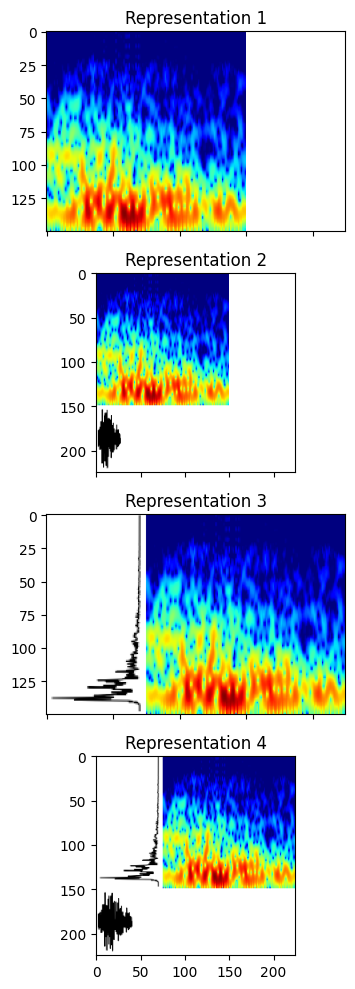

In [9]:
fig, axes = plt.subplots(4,figsize=(5,10),sharex=True)
example_1 = dataset1.__getitem__(idx)[0].permute(1, 2, 0) 
example_2 = dataset2.__getitem__(idx)[0].permute(1, 2, 0) 
example_3 = dataset3.__getitem__(idx)[0].permute(1, 2, 0) 
example_4 = dataset4.__getitem__(idx)[0].permute(1, 2, 0) 
example_1 -= example_1.min()
example_1 /= example_1.max()
example_2 -= example_2.min()
example_2 /= example_2.max()
example_3 -= example_3.min()
example_3 /= example_3.max()
example_4 -= example_4.min()
example_4 /= example_4.max()
axes[0].imshow(example_1)
axes[1].imshow(example_2)
axes[2].imshow(example_3)
axes[3].imshow(example_4)
axes[0].set_title('Representation 1')
axes[1].set_title('Representation 2')
axes[2].set_title('Representation 3')
axes[3].set_title('Representation 4')
plt.tight_layout()
plt.show()

## 5x2 Cross-Validation Training

Select Representation Type

In [10]:
rep_type = 2

Create data splits

In [11]:
train_val_df = (
    data_dir_df.groupby("event_class")
    .apply(lambda x: x.sample(n=1000, replace=False), include_groups=False)
    .reset_index()
)
train_val_indices = train_val_df.index
test_df = data_dir_df.drop(train_val_indices).reset_index()

train_val_dataset = data_utils.CustomImageDataset(train_val_df, rep_type=rep_type)

In [ ]:
super_top_f1 = 0
metrics_list = []
for seed_idx, seed in enumerate([42, 100, 1, 999, 78]):
    kf = KFold(n_splits=2, shuffle=True, random_state=seed)
    for fold_idx, (train_indices, val_indices) in enumerate(
        kf.split(train_val_dataset)
    ):
        print(f"Fold {fold_idx + 1}")
        train_loader = DataLoader(
            train_val_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices)
        )
        val_loader = DataLoader(
            train_val_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices)
        )
        model_torch = vgg16_bn()
        model_torch.classifier[6] = nn.Linear(
            in_features=4096, out_features=3, bias=True
        )  # VGG16
        model_torch.classifier.add_module("7", nn.Softmax(dim=1))
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model_torch.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=10, eta_min=5e-8
        )
        model_torch = model_torch.to(device)
        #### TRAINING
        top_f1 = 0
        _= model_torch.train()
        for epoch in range(epochs):
            t_i = time.time()
            running_loss = train_utils.train(
                model_torch,
                train_loader,
                optimizer,
                criterion,
                device,
                epoch,
                batch_verbose,
            )
            scheduler.step()
            current_lr = optimizer.param_groups[0]["lr"]
            print(
                f"ep: {epoch}| lr:{current_lr:.2e}| fold {fold_idx + 1}| seed: {seed_idx+1}"
            )
            print("Validating...")
            eval_losses, accuracy, recall, f1, mean_spec, specificity, cm = (
                train_utils.validate(model_torch, val_loader, device=device)
            )
            t_f = time.time()
            train_utils.print_time(t_i, t_f)
            metrics_list.append(
                [
                    rep_type,
                    fold_idx + 1,
                    seed_idx + 1,
                    epoch,
                    eval_losses,
                    accuracy,
                    recall,
                    f1,
                    mean_spec,
                    specificity,
                    cm,
                ]
            )
            # conditional save
            if f1 > top_f1:
                print(f"updating {top_f1:.2f} -> {f1:.2f} f1-score")
                top_f1 = f1
            if f1 > super_top_f1:
                print(f"saving weights {top_f1:.2f} -> {f1:.2f} f1-score")
                super_top_f1 = f1
                model_name = f"rep{rep_type}_best_model"
                os.makedirs(f"{current_path}/rep{rep_type}",exist_ok=True)
                PATH = f"{current_path}/{model_name}.pt"
                torch.save(
                    {
                        "epoch": epoch,
                        "model_state_dict": model_torch.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "loss": running_loss,
                    },
                    PATH,
                )
        os.makedirs(f"{current_path}/rep{rep_type}",exist_ok=True)
        cm_path = f"{current_path}/rep{rep_type}/CM_rep{rep_type}_fold{fold_idx+1}_seed{seed_idx+1}.png"

        cm_title = f"Confusion Matrix\nFold {fold_idx+1} | epoch: {epoch}"
        train_utils.cm_save(cm, cm_path, cm_title, clases=["VT", "LP", "TR"])
        # Free GPU memory
    del model_torch
    del optimizer
    del criterion
    free_gpu_memory()
cols = [
    "rep",
    "fold",
    "seed",
    "epoch",
    "val_loss",
    "acc",
    "recall",
    "f1",
    "mean_spec",
    "spec",
    "cm",
]
metrics_df = pd.DataFrame(data=metrics_list, columns=cols)
metrics_df.to_csv(f"{current_path}/rep{rep_type}_5x2_fold.csv", index=False)

Fold 1
